## Required Inputs Before Running

Ensure the following files are present in the `data/` directory (or adjust paths accordingly):

1.  **`usa_pop_2022_CN_100m_R2025A_v1.tif`**: WorldPop Population Raster (100m resolution).
2.  **`VIIRS_Region_2022.tif`**: VIIRS Nighttime Lights raster covering the full multi-county region. (Rename your local VIIRS file to this or update the path in the code).
3.  **`Sentinel2_Region_2022.tif`**: Sentinel-2 Cloud-Free Composite raster covering the full multi-county region. (Rename your local Sentinel file to this or update the path in the code).
4.  **`roads.gpkg`** (Optional): If you already have a road network file, otherwise the script will attempt to download it via OSMnx.

**Note:** The script will generate `ground_truth_neighboring.csv` and various GeoJSON files automatically.

In [1]:
import ee
ee.Authenticate()
ee.Initialize(project="socioeconomic-mapping")

In [3]:
pip install geedim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 3.1 MB/s eta 0:00:00


In [12]:
import os
import geemap

# Ensure geemap is installed
try:
    import geemap
except ImportError:
    print("Installing geemap...")
    !pip install -q geemap
    import geemap

# Configuration
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)
OUTPUT_FILENAME = "VIIRS_Region_2022.tif"
OUTPUT_PATH = os.path.join(DATA_DIR, OUTPUT_FILENAME)

# Target Counties (Virginia - State FIPS 51)
STATE_FIPS = "51"
COUNTY_FIPS = [
    "121", # Montgomery
    "045", # Craig
    "161", # Roanoke
    "770", # Independent City of Roanoke
    "775", # Independent City of Salem
    "063", # Floyd
    "155", # Pulaski
    "071", # Giles
    "750"  # Radford City
]

print("Defining region of interest...")
# Use TIGER boundaries for the region
counties = ee.FeatureCollection("TIGER/2018/Counties")
region = counties.filter(ee.Filter.eq("STATEFP", STATE_FIPS)) \
                 .filter(ee.Filter.inList("COUNTYFP", COUNTY_FIPS))

roi = region.geometry()

print("Processing VIIRS 2022 data (Mean Annual Radiance)...")
# VIIRS Nighttime Lights - Monthly Stray Light Corrected (VCMSLCFG)
viirs_collection = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .filterDate("2022-01-01", "2022-12-31") \
    .select("avg_rad")

# Calculate mean for the year and clip to region
viirs_2022 = viirs_collection.mean().clip(roi)

print(f"Downloading to {OUTPUT_PATH}...")
# Download the image
geemap.download_ee_image(
    image=viirs_2022,
    filename=OUTPUT_PATH,
    region=roi,
    scale=500,  # Approx 500m resolution
    crs="EPSG:4326"
)

print("Download complete.")

Defining region of interest...
Processing VIIRS 2022 data (Mean Annual Radiance)...


  0%|          |0/1 tiles [00:00<?]

Download complete.


In [13]:
import geopandas as gpd
import os
from shapely.ops import unary_union

# Assuming DATA_DIR and COUNTIES are defined in a previous cell
# If running this cell independently, ensure they are defined:
# DATA_DIR = "data"
COUNTIES = {
     "Montgomery": "121", "Craig": "045", "Roanoke": "161",
     "Floyd": "063", "Pulaski": "155", "Giles": "071", "Radford City": "750",
     "Salem City": "775", "Roanoke City": "770"
 }

output_path = os.path.join(DATA_DIR, "region_boundary.geojson")

print("Downloading County Boundaries...")
try:
    counties_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip")

    # Filter for our target counties in Virginia (State 51)
    target_fips = list(COUNTIES.values())
    region_counties = counties_gdf[
        (counties_gdf["STATEFP"] == "51") &
        (counties_gdf["COUNTYFP"].isin(target_fips))
    ].copy()

    # Create a unified boundary for the region
    region_boundary_geom = unary_union(region_counties.geometry)
    region_boundary = gpd.GeoDataFrame(geometry=[region_boundary_geom], crs=region_counties.crs)

    # Save to the data folder as requested
    region_boundary.to_file(output_path, driver="GeoJSON")
    print(f"Successfully saved region_boundary.geojson to {output_path}")

except Exception as e:
    print(f"Error generating and saving region_boundary.geojson: {e}")

Successfully saved region_boundary.geojson to data/region_boundary.geojson


In [14]:
import geopandas as gpd
import geemap
import os

# Load the region boundary GeoJSON
aligned_data_dir = "data/"
region_boundary_path = os.path.join(aligned_data_dir, "region_boundary.geojson")

if os.path.exists(region_boundary_path):
    region_boundary = gpd.read_file(region_boundary_path)

    # Create a geemap object
    m = geemap.Map()

    # Add the region boundary to the map
    # Geemap expects ee.FeatureCollection or GeoDataFrame
    m.add_gdf(region_boundary, layer_name="Target Region Boundary")

    # Center the map on the region
    if not region_boundary.empty:
        centroid = region_boundary.geometry.centroid.iloc[0]
        m.set_center(centroid.x, centroid.y, zoom=8)

    # Display the map
    print("Displaying the target region boundary:")
    m
else:
    print(f"Error: {region_boundary_path} not found. Please ensure previous steps to generate it were successful.")

Displaying the target region boundary:


In [15]:
m

Map(center=[37.184504000000004, -80.4270155], controls=(WidgetControl(options=['position', 'transparent_bg'], …

In [17]:
pip install censusdata osmnx rioxarray contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00
  Created wheel for censusdata: filename=CensusData-1.15.post1-py3-none-any.whl size=28205744 sha256=e78e67a5248c3b540116a5b478bb518de2984a33064c1a69ad035bc2a01c2a21
  Stored in directory: /root/.cache/pip/wheels/54/5e/eb/518ccd7738e6b9b35d9fb3d226d45979066ec367ed26ad1369
Successfully built censusdata


In [19]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import contextily as ctx # Commented out for now
from shapely.geometry import Point, Polygon, box
from shapely.ops import unary_union
import censusdata
import osmnx as ox
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats

# Configuration
DATA_DIR = "data"
ALIGNED_DIR = "data/aligned_data"
OUTPUT_DIR = "outputs"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(ALIGNED_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# CRS Settings
# EPSG:4326 for storage/lat-lon
# NOTE: User requested everything to be projected to EPSG:4326.
# This means distance and area calculations will be in degrees, not meters/sq km.
CRS_LATLON = "EPSG:4326"
CRS_PROJECTED = "EPSG:4326" # Changed from EPSG:32617 to EPSG:4326 as per user request

# County FIPS Codes for Virginia (State FIPS 51)
COUNTIES = {
    "Montgomery": "121",
    "Craig": "045",
    "Roanoke": "161", # Roanoke County
    "Roanoke City": "770", # Independent City of Roanoke
    "Salem City": "775", # Independent City of Salem
    "Floyd": "063",
    "Pulaski": "155",
    "Giles": "071",
    "Radford City": "750"
}

print("Configuration loaded.")

Configuration loaded.


## 1. Data Collection: Boundaries & Block Groups

Loaded 9 counties.


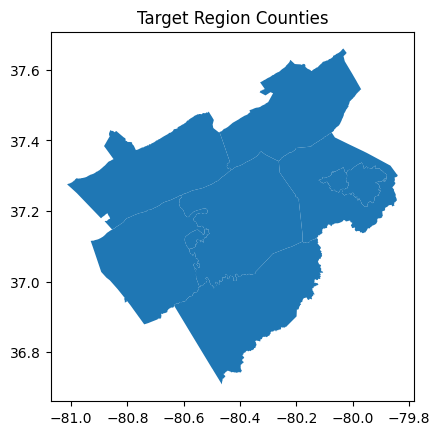

Loaded 293 block groups.


In [20]:
# 1.1 Download County Boundaries
print("Downloading County Boundaries...")
try:
    counties_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip")

    # Filter for our target counties in Virginia (State 51)
    target_fips = list(COUNTIES.values())
    region_counties = counties_gdf[
        (counties_gdf["STATEFP"] == "51") &
        (counties_gdf["COUNTYFP"].isin(target_fips))
    ].copy()

    # Create a unified boundary for the region
    region_boundary_geom = unary_union(region_counties.geometry)
    region_boundary = gpd.GeoDataFrame(geometry=[region_boundary_geom], crs=region_counties.crs)

    # Save
    region_counties.to_file(os.path.join(ALIGNED_DIR, "region_counties.geojson"), driver="GeoJSON")
    region_boundary.to_file(os.path.join(ALIGNED_DIR, "region_boundary.geojson"), driver="GeoJSON")

    print(f"Loaded {len(region_counties)} counties.")
    region_counties.plot()
    plt.title("Target Region Counties")
    plt.show()

except Exception as e:
    print(f"Error downloading boundaries: {e}")

# 1.2 Download Block Groups
print("Downloading Block Groups...")
try:
    bg_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/BG/tl_2023_51_bg.zip")

    # Filter for target counties
    region_bgs = bg_gdf[
        (bg_gdf["STATEFP"] == "51") &
        (bg_gdf["COUNTYFP"].isin(target_fips))
    ].copy()

    # Save
    region_bgs.to_file(os.path.join(ALIGNED_DIR, "block_groups_neighboring.geojson"), driver="GeoJSON")
    print(f"Loaded {len(region_bgs)} block groups.")

except Exception as e:
    print(f"Error downloading block groups: {e}")

## 2. Data Collection: ACS Ground Truth (Income, Population, Poverty)

In [21]:
# Variables to download
# B19013_001E: Median Household Income
# B01003_001E: Total Population
# B17021_002E: Income in the past 12 months below poverty level
# B17021_001E: Total population for whom poverty status is determined

variables = [
    'B19013_001E', # Median Household Income
    'B01003_001E', # Total Population
    'B17021_002E', # Poverty Count
    'B17021_001E'  # Poverty Total
]

dfs = []

print("Downloading ACS Data...")
for county_name, county_fips in COUNTIES.items():
    try:
        print(f"  Fetching data for {county_name} ({county_fips})...")
        county_data = censusdata.download(
            'acs5',
            2022,
            censusdata.censusgeo([
                ('state', '51'),
                ('county', county_fips),
                ('block group', '*')
            ]),
            variables
        )
        dfs.append(county_data)
    except Exception as e:
        print(f"  Error fetching {county_name}: {e}")

if dfs:
    acs_data = pd.concat(dfs)

    # Helper to extract GEOID
    def extract_geoid(index):
        # censusdata index is an object with params() method
        params = dict(index.params())
        return params['state'] + params['county'] + params['tract'] + params['block group']

    acs_data['GEOID'] = acs_data.index.map(extract_geoid)

    # Process Columns
    # Income
    acs_data['median_income'] = acs_data['B19013_001E'].where(acs_data['B19013_001E'] >= 0)

    # Population
    acs_data['population'] = acs_data['B01003_001E'].where(acs_data['B01003_001E'] >= 0)

    # Poverty Rate
    poverty_total = acs_data['B17021_001E'].where(acs_data['B17021_001E'] > 0)
    poverty_count = acs_data['B17021_002E'].where(acs_data['B17021_002E'] >= 0)
    acs_data['poverty_rate'] = poverty_count / poverty_total

    # Select final columns
    ground_truth = acs_data[['GEOID', 'median_income', 'population', 'poverty_rate']].copy()

    # Save
    ground_truth.to_csv(os.path.join(DATA_DIR, "ground_truth_neighboring.csv"), index=False)
    print(f"Saved ground truth data with {len(ground_truth)} records.")
    print(ground_truth.head())
else:
    print("No ACS data downloaded.")

  Fetching data for Montgomery (121)...
  Fetching data for Craig (045)...
  Fetching data for Roanoke (161)...
  Fetching data for Roanoke City (770)...
  Fetching data for Salem City (775)...
  Fetching data for Floyd (063)...
  Fetching data for Pulaski (155)...
  Fetching data for Giles (071)...
  Fetching data for Radford City (750)...
Saved ground truth data with 293 records.
                                                           GEOID  \
Block Group 1; Census Tract 201; Montgomery Cou...  511210201001   
Block Group 2; Census Tract 201; Montgomery Cou...  511210201002   
Block Group 1; Census Tract 202.01; Montgomery ...  511210202011   
Block Group 2; Census Tract 202.01; Montgomery ...  511210202012   
Block Group 3; Census Tract 202.01; Montgomery ...  511210202013   

                                                    median_income  population  \
Block Group 1; Census Tract 201; Montgomery Cou...            NaN        1938   
Block Group 2; Census Tract 201; Montgomery 

## 3. Data Collection: OpenStreetMap (OSM)

In [22]:
# Use the unified region boundary for OSM queries
region_poly = region_boundary.geometry.iloc[0]

# 3.1 Healthcare
print("Fetching Healthcare facilities...")
try:
    healthcare = ox.features_from_polygon(
        region_poly,
        tags={"amenity": ["hospital", "clinic", "doctors", "pharmacy"]}
    )
    healthcare = healthcare.reset_index(drop=True)
    healthcare = healthcare[['geometry', 'amenity', 'name']] # Keep relevant cols
    healthcare.to_file(os.path.join(ALIGNED_DIR, "healthcare_neighboring.geojson"), driver="GeoJSON")
    print(f"  Fetched {len(healthcare)} healthcare facilities.")
except Exception as e:
    print(f"  Error fetching healthcare: {e}")

# 3.2 Schools
print("Fetching Schools...")
try:
    schools = ox.features_from_polygon(
        region_poly,
        tags={"amenity": ["school", "college", "university"]}
    )
    schools = schools.reset_index(drop=True)
    schools = schools[['geometry', 'amenity', 'name']]
    schools.to_file(os.path.join(ALIGNED_DIR, "schools_neighboring.geojson"), driver="GeoJSON")
    print(f"  Fetched {len(schools)} schools.")
except Exception as e:
    print(f"  Error fetching schools: {e}")

# 3.3 Grocery (NO FILTERING)
print("Fetching Grocery stores...")
try:
    grocery = ox.features_from_polygon(
        region_poly,
        tags={"shop": ["supermarket", "convenience", "grocery"]}
    )
    grocery = grocery.reset_index(drop=True)
    # Keep all columns or just relevant ones? Let's keep geometry and shop type
    grocery = grocery[['geometry', 'shop', 'name']]
    grocery.to_file(os.path.join(ALIGNED_DIR, "grocery_neighboring.geojson"), driver="GeoJSON")
    print(f"  Fetched {len(grocery)} grocery stores.")
except Exception as e:
    print(f"  Error fetching grocery: {e}")

# 3.4 Roads
print("Fetching Road Network (this may take a while)...")
roads_path = os.path.join(DATA_DIR, "roads.gpkg")
if not os.path.exists(roads_path):
    try:
        # Download graph
        G = ox.graph_from_polygon(region_poly, network_type='drive')
        # Convert to GeoDataFrame
        nodes, edges = ox.graph_to_gdfs(G)
        # Save edges as roads
        edges.to_file(roads_path, driver="GPKG")
        print(f"  Fetched {len(edges)} road segments.")
    except Exception as e:
        print(f"  Error fetching roads: {e}")
else:
    print("  Roads file already exists.")

Fetching Healthcare facilities...
  Fetched 123 healthcare facilities.
Fetching Schools...
  Fetched 177 schools.
Fetching Grocery stores...
  Fetched 223 grocery stores.
Fetching Road Network (this may take a while)...
  Fetched 53089 road segments.


## 4. Feature Engineering

In [23]:
# Load Block Groups and Reproject for Distance Calculations
bgs = gpd.read_file(os.path.join(ALIGNED_DIR, "block_groups_neighboring.geojson"))
bgs = bgs.to_crs(CRS_PROJECTED)

# Calculate Centroids
bgs['centroid'] = bgs.geometry.centroid

# Initialize Feature Matrix with GEOID
features = bgs[['GEOID']].copy()

# Helper function for OSM features
def calculate_osm_features(gdf_path, name_prefix, block_groups_gdf):
    print(f"Processing {name_prefix}...")
    if not os.path.exists(gdf_path):
        print(f"  Warning: {gdf_path} not found. Skipping.")
        return pd.DataFrame({'GEOID': block_groups_gdf['GEOID']})

    poi_gdf = gpd.read_file(gdf_path).to_crs(CRS_PROJECTED)

    # 1. Count of POIs within Block Group
    # Spatial Join
    joined = gpd.sjoin(poi_gdf, block_groups_gdf, how="inner", predicate="intersects")
    counts = joined.groupby("GEOID").size().reset_index(name=f"{name_prefix}_count")

    # 2. Distance to Nearest POI
    # Use centroids of block groups
    # For efficiency, use nearest_points or cKDTree if dataset is large,
    # but for this scale, simple distance matrix or apply might work.
    # Let's use geometry.distance to the unary_union of POIs (or nearest)

    # Better approach for distance:
    # For each BG centroid, find distance to nearest POI geometry
    # Using apply with distance to the whole POI set is slow.
    # Using cKDTree on POI centroids is faster.

    poi_centroids = poi_gdf.geometry.centroid

    def get_min_dist(point):
        return poi_centroids.distance(point).min()

    # Note: This can still be slow.
    # Optimization: Use sindex.nearest

    min_dists = []
    for geom in block_groups_gdf.centroid:
        # Find nearest index
        nearest_idx = list(poi_gdf.sindex.nearest(geom, return_all=False))[1][0]
        nearest_geom = poi_gdf.iloc[nearest_idx].geometry
        dist = geom.distance(nearest_geom)
        min_dists.append(dist)

    dist_df = pd.DataFrame({
        'GEOID': block_groups_gdf['GEOID'],
        f'{name_prefix}_nearest_dist': min_dists
    })

    return counts.merge(dist_df, on="GEOID", how="outer")

# 4.1 Calculate OSM Features
# Healthcare
health_feats = calculate_osm_features(os.path.join(ALIGNED_DIR, "healthcare_neighboring.geojson"), "health", bgs)
features = features.merge(health_feats, on="GEOID", how="left")

# Schools
school_feats = calculate_osm_features(os.path.join(ALIGNED_DIR, "schools_neighboring.geojson"), "school", bgs)
features = features.merge(school_feats, on="GEOID", how="left")

# Grocery
grocery_feats = calculate_osm_features(os.path.join(ALIGNED_DIR, "grocery_neighboring.geojson"), "grocery", bgs)
features = features.merge(grocery_feats, on="GEOID", how="left")

# Fill NaNs in counts with 0 (distance NaNs should remain if no POIs found, but here we likely found some)
features[[c for c in features.columns if 'count' in c]] = features[[c for c in features.columns if 'count' in c]].fillna(0)

print("OSM Features Calculated.")
features.head()

Processing health...
Processing school...
Processing grocery...
OSM Features Calculated.


,GEOID,health_count,health_nearest_dist,school_count,school_nearest_dist,grocery_count,grocery_nearest_dist
0,511210215013,0.0,0.049399,0.0,0.038235,0.0,0.042076
1,511210215011,0.0,0.021386,0.0,0.039141,0.0,0.029663
2,511210215012,2.0,0.039695,0.0,0.068976,0.0,0.075621
3,511210212012,0.0,0.083365,1.0,0.033536,1.0,0.039001
4,511210208011,0.0,0.040129,0.0,0.033337,3.0,0.028465


In [25]:
# 4.2 Road Density
print("Calculating Road Density...")
roads_path = os.path.join(DATA_DIR, "roads.gpkg")
if os.path.exists(roads_path):
    # Removed layer='edges' to read the default layer, as 'edges' layer was not found.
    roads = gpd.read_file(roads_path).to_crs(CRS_PROJECTED)

    # Spatial Join to assign road segments to block groups
    # This splits roads at BG boundaries if we use overlay, but sjoin just checks intersection.
    # For density, we ideally want length of roads *within* the BG.
    # Overlay is expensive.
    # Approximation: Clip roads to BGs?

    # Let's use overlay intersection for accurate length
    roads_clipped = gpd.overlay(roads, bgs[['GEOID', 'geometry']], how='intersection')
    roads_clipped['length_m'] = roads_clipped.length

    road_stats = roads_clipped.groupby('GEOID')['length_m'].sum().reset_index()
    road_stats.rename(columns={'length_m': 'road_length_m'}, inplace=True)

    # Calculate Density (m per sq km)
    bgs['area_sqkm'] = bgs.geometry.area / 10**6
    road_stats = bgs[['GEOID', 'area_sqkm']].merge(road_stats, on='GEOID', how='left').fillna(0)
    road_stats['road_density'] = road_stats['road_length_m'] / road_stats['area_sqkm']

    features = features.merge(road_stats[['GEOID', 'road_density']], on='GEOID', how='left')
    print("Road Density Calculated.")
else:
    print("Roads file not found. Skipping density.")

Calculating Road Density...
Road Density Calculated.


Downloading Sentinel Data

In [26]:
def maskS2(image):
    qa = image.select('QA60')
    cloud = qa.bitwiseAnd(1 << 10).neq(0).Or(qa.bitwiseAnd(1 << 11).neq(0))
    return image.updateMask(cloud.Not())

In [ ]:
import geemap

# Ensure the GeoDataFrame is in EPSG:4326 for Earth Engine
# This avoids potential CRS mismatch issues
if region_boundary.crs != "EPSG:4326":
    region_boundary_ee = region_boundary.to_crs("EPSG:4326")
else:
    region_boundary_ee = region_boundary

# Convert the GeoDataFrame to an Earth Engine object
# We use the geometry of the feature collection
ee_region_boundary = geemap.gdf_to_ee(region_boundary_ee).geometry()

In [29]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
          .filterDate('2022-01-01', '2023-01-01') \
          .filterBounds(ee_region_boundary) \
          .map(maskS2) \
          .median() \
          .clip(ee_region_boundary)

EEException: Invalid GeoJSON geometry.

In [ ]:
s2_bands = s2.select(['B8', 'B4', 'B11'])

In [ ]:
# Download the image directly to the data directory
output_sentinel = os.path.join(DATA_DIR, "Sentinel2_Region_2022.tif")
print(f"Downloading Sentinel-2 data to {output_sentinel}...")

if os.path.exists(output_sentinel):
    print("Sentinel-2 data already exists. Skipping download.")
else:
    geemap.download_ee_image(
        image=s2_bands,
        filename=output_sentinel,
        region=ee_region_boundary,
        scale=10,
        crs="EPSG:4326"
    )
    print("Download complete.")

Export started. Check the Tasks tab in GEE or Drive.


In [ ]:
# This cell is redundant as ee_region_boundary is already defined and used above.
# Also the path was incorrect.
# import geopandas as gpd
# import os

# # Define the path to the region boundary file
# aligned_data_dir = "data/aligned_data"
# region_boundary_path = os.path.join(aligned_data_dir, "region_boundary.geojson")

# # Check if the file exists, and load it
# if os.path.exists(region_boundary_path):
#     region_boundary_gdf = gpd.read_file(region_boundary_path)
#     # Convert the GeoJSON geometry to an Earth Engine geometry object
#     ee_region_boundary = ee.Geometry.MultiPolygon(region_boundary_gdf.geometry.to_json())
#     print("Earth Engine region boundary created from GeoJSON.")
# else:
#     print(f"Error: {region_boundary_path} not found. Please ensure it has been generated.")

In [ ]:
# 4.3 Raster Features (Population, VIIRS, Sentinel)

def calculate_raster_stats(raster_path, name_prefix, block_groups_gdf, stats=['mean', 'median']):
    print(f"Processing {name_prefix} from {raster_path}...")
    if not os.path.exists(raster_path):
        print(f"  Warning: {raster_path} not found. Skipping.")
        return None

    # Read raster
    # We use rasterstats which handles projection matching if we pass the affine transform?
    # Actually rasterstats expects the raster and vector to be in the same CRS or the raster path to be handled.
    # Best practice: Reproject vector to raster CRS.

    with rasterio.open(raster_path) as src:
        raster_crs = src.crs
        raster_transform = src.transform
        raster_array = src.read(1)
        nodata = src.nodata

    # Reproject BGs to Raster CRS
    bgs_raster_crs = block_groups_gdf.to_crs(raster_crs)

    # Calculate Stats
    stats_list = zonal_stats(
        bgs_raster_crs,
        raster_path,
        stats=stats
    )

    stats_df = pd.DataFrame(stats_list)
    stats_df.columns = [f"{name_prefix}_{c}" for c in stats_df.columns]
    stats_df['GEOID'] = block_groups_gdf['GEOID'].values

    return stats_df

# Population
pop_path = os.path.join(DATA_DIR, "usa_pop_2022_CN_100m_R2025A_v1.tif")
pop_stats = calculate_raster_stats(pop_path, "pop", bgs, stats=['sum', 'mean'])
if pop_stats is not None:
    features = features.merge(pop_stats, on="GEOID", how="left")

# VIIRS Nightlights
viirs_path = os.path.join(DATA_DIR, "VIIRS_Region_2022.tif")
viirs_stats = calculate_raster_stats(viirs_path, "viirs", bgs, stats=['mean', 'max'])
if viirs_stats is not None:
    features = features.merge(viirs_stats, on="GEOID", how="left")

# Sentinel-2 (NDVI/Bands)
# Assuming the Sentinel file is a composite or specific band.
# If it's a multi-band raster, we might want stats for specific bands.
# For now, assuming single band or just taking stats of the first band (often RGB or composite).
# If the user has a multi-band file, they might need to adjust this to read specific bands.
sentinel_path = os.path.join(DATA_DIR, "Sentinel2_Region_2022.tif")
sentinel_stats = calculate_raster_stats(sentinel_path, "sentinel", bgs, stats=['mean', 'std'])
if sentinel_stats is not None:
    features = features.merge(sentinel_stats, on="GEOID", how="left")

print("Raster Features Calculated.")
features.head()

## 5. Consolidation and Output

In [ ]:
# Merge with Ground Truth
ground_truth = pd.read_csv(os.path.join(DATA_DIR, "ground_truth_neighboring.csv"))
# Ensure GEOID is string
ground_truth['GEOID'] = ground_truth['GEOID'].astype(str)
features['GEOID'] = features['GEOID'].astype(str)

master_matrix = features.merge(ground_truth, on="GEOID", how="left")

# Handle Missing Values
# Drop rows where target (median_income) is missing?
# Or keep them for prediction?
# For training, we need the target.
print(f"Total Block Groups: {len(master_matrix)}")
print(f"Block Groups with Income Data: {master_matrix['median_income'].notna().sum()}")

# Save
output_file = "master_feature_matrix_neighboring_counties.csv"
master_matrix.to_csv(output_file, index=False)
print(f"Successfully saved {output_file}")

# Preview
print(master_matrix.info())
master_matrix.head()